# 推論の実施
## 推論の実施
本来であれば batch_size = 32 で50,000イテレーションかけてネットワークを学習させるが，ここではマシンの都合上 batch_size = 8 で約35,500イテレーションかけて学習したモデルで推論を行う．
前節で学習した ssd300_50.pth をロードして用いる．

In [1]:
import torch
from utils.forward import SSD

voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
               'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

# SSD300 の設定
ssd_cfg = {
    'num_classes': 21, # 背景クラスを含めた合計クラス数
    'input_size': 300, # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],      # 出力するデフォルトボックスのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],      # 各 source の画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],         # デフォルトボックスの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # デフォルトボックスの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315], # デフォルトボックスの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]]
}

# SSD ネットワークモデル
net = SSD(phase="inference", cfg=ssd_cfg)

# SSD の学習済みの重みを設定
net_weights = torch.load("./weights/ssd300_50.pth", map_location={"cuda:0": "cpu"})

net.load_state_dict(net_weights)

print(' ネットワーク設定完了:学習済みの重みをロードしました ')

 ネットワーク設定完了:学習済みの重みをロードしました 


data フォルダ内の乗馬の画像を使って推論を行う．

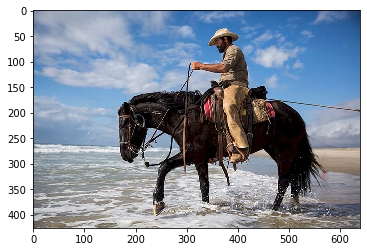

torch.Size([1, 21, 200, 5])
tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

         [[3.2859e-02, 7.8423e-04, 5.9659e-01, 9.5680e-02, 6.6436e-01],
          [2.4478e-02, 7.3408e-01, 2.4517e-01, 8.4693e-01, 3.1436e-01],
          [1.9425e-02, 1.5964e-02, 8.3430e-01, 1.5872e-01, 9.0003e-01],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]],

         [[5.3674e-02, 2.4681e-01, 2.0278e-01, 8.3631e-01, 9.3308e-01],
  

/pytorch/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [2]:
import cv2
from matplotlib import pyplot as plt
from utils.dataset import DataTransform

# 1. 画像の読み込み
image_file_path = "./data/cowboy-757575_640.jpg"
img = cv2.imread(image_file_path)
height, width, channels = img.shape

# 2. 元画像の表示
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 3. 前処理クラスの作成
color_mean = (104, 117, 123)
input_size = 300
transform = DataTransform(input_size, color_mean)

# 4. 前処理
phase = "val"
img_transformed, boxes, labels = transform(img, phase, "", "")  # アノテーションデータはなし
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# 5. SSD で予測
net.eval()
x = img.unsqueeze(0)  # ミニバッチ化（torch.Size([1, 3, 300, 300]）
detections = net(x)

print(detections.shape)
print(detections)

出力結果は (1, 21, 200, 5) のテンソルとなっている．
確信度 conf が一定（ここでは0.6）以上のバウンディングボックスのみを表示する．  
表示には ./utils/ssd_predict_show.py に用意してある SSDPredictShow を用いる．

/pytorch/torch/csrc/autograd/python_function.cpp:638: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)
/pytorch/torch/csrc/autograd/python_function.cpp:664: UserWarning: Legacy autograd function object was called twice.  You will probably get incorrect gradients from this computation, as the saved tensors from the second invocation will clobber the saved tensors from the first invocation.  Please consider rewriting your autograd function in the modern style; for information on the new format, please see: https://pytorch.org/docs/stable/notes/extending.html#extending-torch-autograd


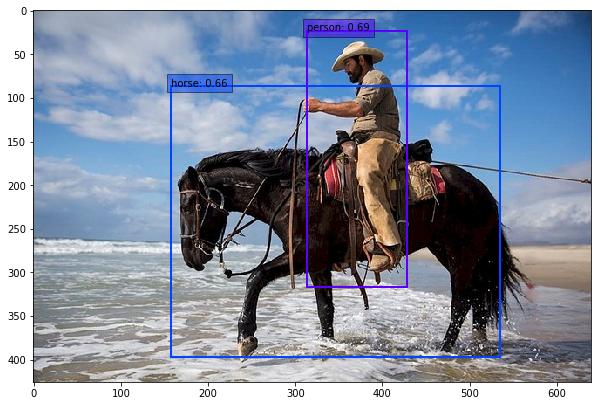

In [7]:
from utils.ssd_predict_show import SSDPredictShow

# 予測と予測結果を画像上に表示
ssd = SSDPredictShow(eval_categories=voc_classes, net=net)
ssd.show(image_file_path, data_confidence_level=0.6)

ここでは 50 epoch しか学習していないため制度が上がりきっていないが，うまく人と馬をうまく検出できている．